In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook requires a pair of untransformed and annotation-based transformed embeddings. The snakemake worflow in this repository contains rules for generating these embedding pairs with UMAP for FAUST annotations (`{name}_embedding_output.parquet` ). An example pair can be generated via,

```bash
snakemake --cores all \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap.parquet \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap_annotated.parquet
```

which downloads [sample annotations](https://figshare.com/articles/dataset/ISMB_BioVis_2022_Data/20301639) from figshare and executes the embedding rules automatically.


In [16]:
import pathlib

import jscatter
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../")  # for local modules
import lib.colors
import lib.metrics
import lib.transformation

data_dir = pathlib.Path.cwd() / ".." / "data" / "mair-2022-ismb"
name = "TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595"

raw = pd.read_parquet(data_dir / f"{name}_umap_annotated.parquet")
annotated = pd.read_parquet(data_dir / f"{name}_umap.parquet")
raw_knn_indices = lib.metrics.kneighbors(raw[["x", "y"]], k=100)
ann_knn_indices = lib.metrics.kneighbors(annotated[["x", "y"]], k=100)

# point–point comparison (*k* 1–10)

- Jaccard distance: $\frac{ | A \cap B | }{ | A \cup B | } = \frac{ | A \cap B | }{ | A | + | B | - | A \cap B | }$


In [17]:
pairwise_distances = {
    k: lib.metrics.jaccard_pointwise(raw_knn_indices[:, 1:k], ann_knn_indices[:, 1:k])
    for k in (3, 5, 10, 20, 30, 40, 60, 99)
}

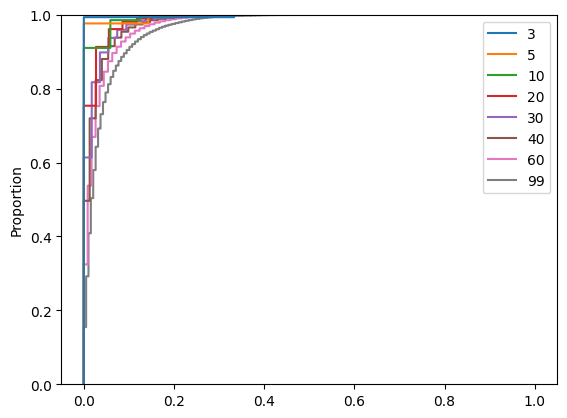

In [18]:
sns.ecdfplot(pairwise_distances);

# label–point comparison

- "group-wise" Jaccard distance: $\frac{\bigcup_{i \in I} A_i \cap B_i}{\bigcup_{i \in I} A_i \cup B_i}$, where $I$ is a set of points with a given label

In [19]:
groupwise_distances = {
    k: lib.metrics.jaccard_groupwise(
        raw_knn_indices[:, :k], ann_knn_indices[:, 1 : k + 1], raw.cellType
    )
    for k in (1, 2, 3, 5, 10, 20, 30)
}

In [20]:
groupwise_distances[20].head()

,label,score
0,0_0_0_0_0,0.063891
1,CD4+CD8+CD3+CD45RA+CD27+CD19-CD103-CD28+CD69+P...,0.012346
2,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103+CD28+CD69+P...,0.046154
3,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103+CD28+CD69+P...,0.027397
4,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103-CD28+CD69+P...,0.004317


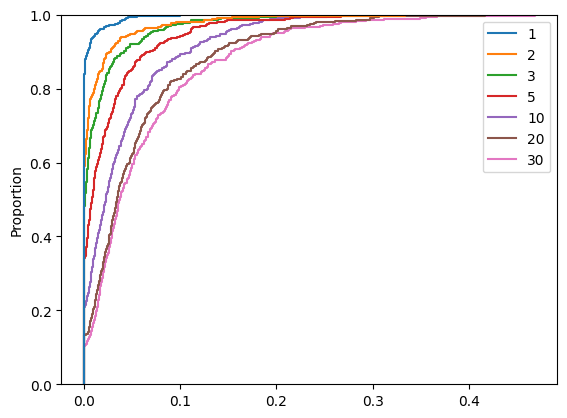

In [21]:
sns.ecdfplot({k: v["score"] for k, v in groupwise_distances.items()});

- Alternatively, view the distribution/summary of Jaccard distances for all points in a group

In [22]:
pointwise_ave_distances = {
    k: lib.metrics.jaccard_pointwise_average(
        raw_knn_indices[:, 1 : k + 1], ann_knn_indices[:, 1 : k + 1], raw.cellType
    )
    for k in (1, 2, 3, 5, 10, 20, 30)
}

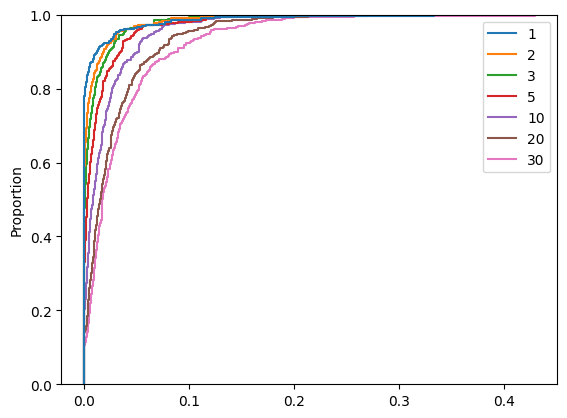

In [23]:
sns.ecdfplot({k: v["score"] for k, v in pointwise_ave_distances.items()});

# label–label comparision

For each point $i$ given $M$ labels,
   - Find *k*NN
   - Count the label occurence of each neighbor in label counts vector $counts_i = (c_1, c_2, ..., c_{M-1}, c_M)$
  
Compare the label counts vector for point $i$ between both datasets (cosine similarity)

In [24]:
# TODO: profile and optimize implementation

k = 100

dist_annotated, dist_raw = (
    lib.metrics.count_labels(ind, raw.cellType)
    for ind in (raw_knn_indices, ann_knn_indices)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110584/110584 [00:51<00:00, 2140.21it/s]


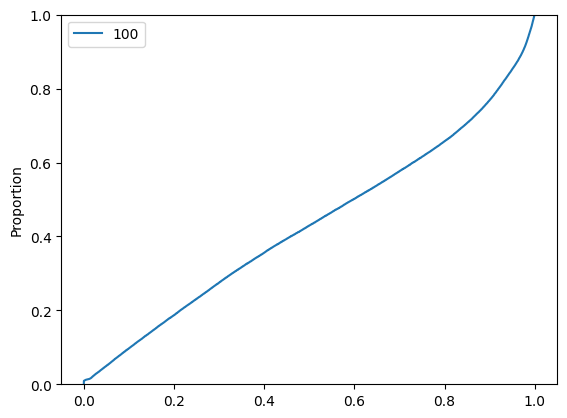

In [25]:
import numpy.linalg as nplg
import numpy.typing as npt


def rowise_cosine_similarity(X0: npt.ArrayLike, X1: npt.ArrayLike):
    """Computes the cosine similary per row of two equally shaped 2D matrices."""
    return np.sum(X0 * X1, axis=1) / (nplg.norm(X0, axis=1) * nplg.norm(X1, axis=1))


point_label_distances = rowise_cosine_similarity(dist_annotated, dist_raw)
sns.ecdfplot({k: point_label_distances});

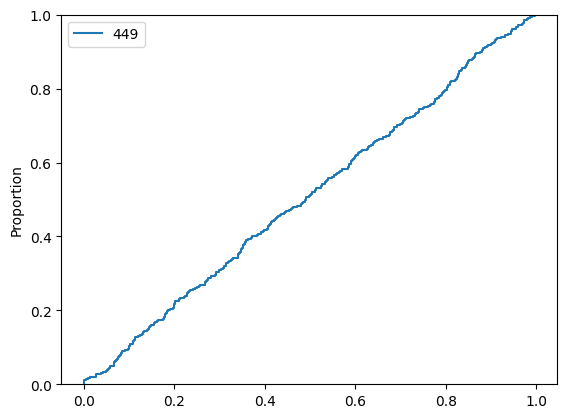

In [26]:
label_label_distances = rowise_cosine_similarity(
    pd.DataFrame(dist_annotated, index=raw.cellType).groupby("cellType").mean(),
    pd.DataFrame(dist_raw, index=raw.cellType).groupby("cellType").mean(),
)
label_label_distances.name = "dist"
counts = raw.cellType.value_counts()
counts.name = "counts"
label_summary = pd.concat([counts, label_label_distances], axis=1)
sns.ecdfplot({len(label_label_distances): label_label_distances});

In [27]:
df = pd.concat(
    [
        pd.Series(raw.cellType, name="label", dtype="category"),
        pd.Series(point_label_distances, name="dist"),
    ],
    axis=1,
)

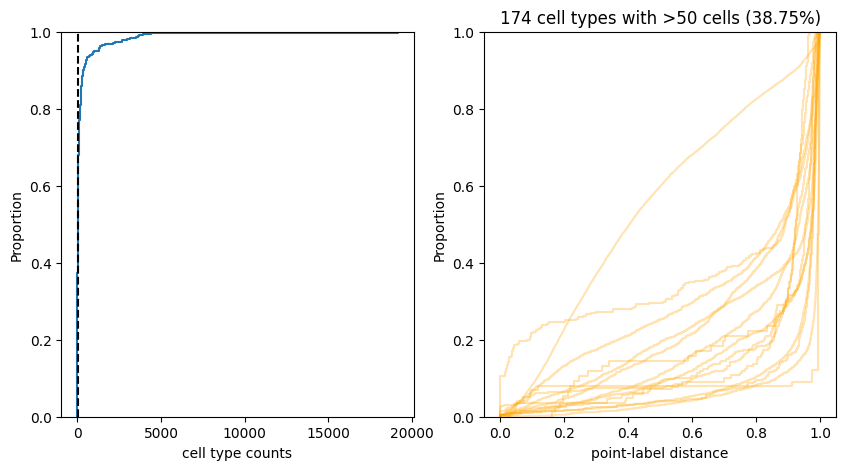

In [28]:
import matplotlib.pyplot as plt

count_threshold = 50
top_k = 15

subset = label_summary[label_summary["counts"] >= count_threshold]

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

a0.set_xlabel("cell type counts")
sns.ecdfplot(label_summary.counts, ax=a0)
a0.axvline(x=count_threshold, color="black", linestyle="--")

a1.set_title(
    f"{len(subset)} cell types with >{count_threshold} cells ({len(subset) / len(label_summary) * 100:.2f}%)"
)
a1.set_xlabel("point-label distance")
for label in subset.sort_values(by="dist", ascending=False)[:top_k].index:
    sns.ecdfplot(df[df["label"] == label]["dist"], alpha=0.3, color="orange", ax=a1)

# embed with distance metrics

In [30]:
# add distance metrics to dataframes
annotated["dist"] = point_label_distances
raw["dist"] = point_label_distances
annotated["label_dist"] = raw.cellType.map(label_label_distances).astype(float)
raw["label_dist"] = raw.cellType.map(label_label_distances).astype(float)

view_config = dict(
    x="x", y="y", background_color="black", axes=False, opacity_unselected=0.05
)

compose_config = dict(sync_selection=True, sync_hover=True, row_height=640, rows=2)

color_map = (
    [lib.colors.gray_dark]
    + lib.colors.glasbey_light
    + lib.colors.glasbey_light
    + lib.colors.glasbey_light
)
view_conf_labels = {"color_by": "cellType", "color_map": color_map, **view_config}
view_conf_distances = {"color_by": "dist", **view_config}

s = jscatter.Scatter(data=annotated, **view_conf_labels)
jscatter.compose(
    [
        s,
        jscatter.Scatter(data=raw, **view_conf_labels),
        jscatter.Scatter(data=annotated, **view_conf_distances),
        jscatter.Scatter(data=raw, **view_conf_distances),
    ],
    **compose_config
)

GridBox(children=(HBox(children=(VBox(children=(Button(button_style='primary', icon='arrows', layout=Layout(wi…

cellType
CD4+CD8-CD3-CD45RA+CD27-CD19-CD103-CD28-CD69-PD1-HLADR+GranzymeB+CD25-ICOS-TCRgd-CD38+CD127-Tim3-    0.996341
CD4-CD8-CD3-CD45RA+CD27-CD19+CD103-CD28-CD69-PD1-HLADR+GranzymeB-CD25-ICOS-TCRgd-CD38-CD127-Tim3-    0.991818
CD4-CD8-CD3-CD45RA-CD27-CD19-CD103-CD28-CD69-PD1-HLADR-GranzymeB-CD25-ICOS-TCRgd-CD38+CD127-Tim3-    0.990527
CD4-CD8-CD3-CD45RA-CD27-CD19-CD103-CD28-CD69-PD1-HLADR+GranzymeB-CD25-ICOS-TCRgd-CD38+CD127-Tim3-    0.985049
CD4+CD8-CD3+CD45RA-CD27-CD19-CD103-CD28+CD69-PD1-HLADR+GranzymeB-CD25-ICOS-TCRgd-CD38-CD127-Tim3-    0.980510
CD4-CD8+CD3+CD45RA-CD27-CD19-CD103-CD28-CD69-PD1-HLADR-GranzymeB+CD25-ICOS-TCRgd-CD38+CD127-Tim3-    0.978648
CD4-CD8-CD3-CD45RA+CD27+CD19+CD103-CD28-CD69-PD1-HLADR+GranzymeB-CD25-ICOS-TCRgd-CD38-CD127-Tim3-    0.975865
CD4-CD8-CD3+CD45RA-CD27+CD19-CD103+CD28+CD69+PD1+HLADR-GranzymeB-CD25-ICOS-TCRgd+CD38-CD127-Tim3-    0.972734
CD4+CD8-CD3+CD45RA-CD27-CD19-CD103-CD28+CD69-PD1-HLADR-GranzymeB-CD25-ICOS-TCRgd-CD38-CD127+Tim3-    0.972115
C

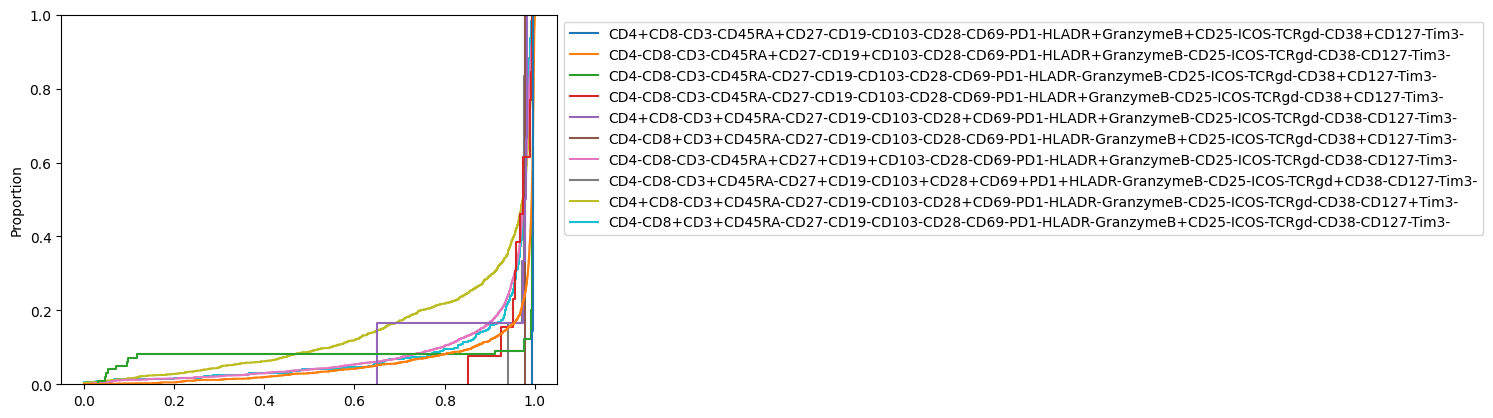

In [31]:
df = pd.DataFrame({"dist": point_label_distances, "label": raw.cellType})
labels = label_label_distances.sort_values(ascending=False)[:10]
print(labels)
ax = sns.ecdfplot({label: df[df["label"] == label]["dist"] for label in labels.index})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [32]:
label = "CD4-CD8-CD3-CD45RA-CD27-CD19-CD103-CD28-CD69-PD1-HLADR-GranzymeB-CD25-ICOS-TCRgd-CD38+CD127-Tim3-"
threshold = 0.9
subset = df[(df.label == label) & (df.dist < threshold)]
s.selection(subset.index)

In [33]:

from sklearn.decomposition import PCA
from umap import UMAP


def embed(df: pd.DataFrame, **kwargs):
    """
    Create an embedding
    """
    markers, expression_levels, expressions = scripts.transformation.prepare(df)
    print(f'Markers: {", ".join(markers)}')
    print(f'Expression Levels: {" and ".join(expression_levels.keys())}')

    pca = PCA(n_components=2).fit_transform(
        df[[f"{m}_Windsorized" for m in markers]].values
    )

    umap_raw = UMAP(init=pca, random_state=42, **kwargs)
    raw = scripts.transformation.embed(df, expressions, umap_raw)

    umap_ann = UMAP(init=pca, random_state=42, **kwargs)
    ann = scripts.transformation.embed(
        df,
        scripts.transformation.transform(df, markers, expression_levels, log=True),
        umap_ann,
    )

    return (raw, umap_raw._knn_indices), (ann, umap_ann._knn_indices)

ModuleNotFoundError: No module named 'scripts'

In [ ]:
import pandas as pd

df = pd.read_parquet(
    "../data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_embedding_output.parquet"
)

(raw, raw_knn_indices), (annotated, ann_knn_indices) = embed(df, n_neighbors=100)